#  Covid-19 in Northern Ireland

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -qq geopandas

In [3]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import warnings

from matplotlib import rcParams

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

rcParams['figure.figsize'] = (18, 6)
rcParams['figure.autolayout'] = True

map = 'http://geoportal1-ons.opendata.arcgis.com/datasets/3a4fa2ce68f642e399b4de07643eeed3_0.geojson?outSR={%22latestWkid%22:27700,%22wkid%22:27700}'
gdf = geopandas.read_file(map)
gdf = gdf[gdf['lad19cd'].str.contains('N')].rename(columns={'lad19cd': 'LTLA'})

2021-11-05 16:54:56.160585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-05 16:54:56.160618: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# population data (Mid-2020 estimates from https://www.ons.gov.uk/peoplepopulationandcommunity)
population = pd.DataFrame(
    {'LTLA':['N09000001', 'N09000002', 'N09000003', 'N09000004', 'N09000005', 'N09000006', 'N09000007', 'N09000008', 'N09000009', 'N09000010', 'N09000011'],
     'count':[143756, 217232, 342560, 144943, 151109, 117337, 146452, 139443, 148953, 181669, 162056]}
)
population_array = population.set_index('LTLA').sort_values(['LTLA'])
population_array

count
LTLA             
N09000001  143756
N09000002  217232
N09000003  342560
N09000004  144943
N09000005  151109
N09000006  117337
N09000007  146452
N09000008  139443
N09000009  148953
N09000010  181669
N09000011  162056

In [5]:
# build contact matrix
mobility = pd.read_csv('https://gitlab.com/chicas-covid19/covid19uk/-/raw/master/data/mergedflows.csv')
mobility = mobility[mobility['From'].str.contains('N') & mobility['To'].str.contains('N')]
mobility = mobility.sort_values(['From', 'To']).groupby(['From', 'To']).agg({'Flow': sum}).reset_index()
contact_matrix = mobility.pivot(index='To', columns='From', values='Flow').fillna(0)
contact_matrix

From       N09000001  N09000002  N09000003  N09000004  N09000005  N09000006  \
To                                                                            
N09000001      23787       1493       5920       1231        197        187   
N09000002        472      44373       1003        172        108        364   
N09000003      19001       7791      75031       2055        788        848   
N09000004        288        111        210      28720       1577        400   
N09000005         94         47        157       3720      34352       1362   
N09000006         35        199        146        481       2263      26956   
N09000007       2428       5482       9290        343        124        159   
N09000008       4100        579       1196       3490        130         78   
N09000009        642       2523        295       1438        707       1892   
N09000010        370       4271        706         45         38         73   
N09000011        783        475       2379         93         31         43   

From       N09000007  N09000008  N09000009  N09000010  N09000011  
To                                                                
N09000001       3430       8420       1717        866       1812  
N09000002       2352        467       2750       3014        459  
N09000003      32857      10006       2713       7218      19221  
N09000004        111       1056       1459         42         65  
N09000005         99         99       1125         38         48  
N09000006         70         32       1731         49         29  
N09000007      25799       1182        438       3045       5706  
N09000008        634      26311       1135        405        479  
N09000009        333        545      28640        217        101  
N09000010       1234        341        183      33378        903  
N09000011       2011        397         77       1054      27033

date       2020-09-01  2020-09-02  2020-09-03  2020-09-04  2020-09-05  \
LTLA                                                                    
N09000001           7           7          12           8          10   
N09000002           7           7          12          22          13   
N09000003          23          38          27          43          23   
N09000004           5           6           2           4           1   
N09000005           4           4           0           2           1   
N09000006           1           1           2           5           2   
N09000007           6          12          11          11           8   
N09000008           5           4          29          11          10   
N09000009           0           1           0           2           5   
N09000010           3           4           8           6           9   
N09000011           1           6           2          11           5   

date       2020-09-06  2020-09-07  2020-09-08  2020-09-09  2020-09-10  ...  \
LTLA                                                                   ...   
N09000001          13          17          10          15          11  ...   
N09000002           9           6           7          12          14  ...   
N09000003          31          20          14          35          22  ...   
N09000004           4           2           0           2           3  ...   
N09000005           0           0           4           4           5  ...   
N09000006           2           0           0           1           2  ...   
N09000007          20           8          12           7           7  ...   
N09000008           4           5           2           8           3  ...   
N09000009           4           3           1           4           0  ...   
N09000010           6           7           3           6           4  ...   
N09000011           6           3           3           3           4  ...   

date       2020-12-10  2020-12-11  2020-12-12  2020-12-13  2020-12-14  \
LTLA                                                                    
N09000001          42          42          16          23          37   
N09000002          56          54          39          53         102   
N09000003          53          72          37          56          63   
N09000004          51          42          30          27          43   
N09000005          44          33          25          33          48   
N09000006          34          24          26          28          30   
N09000007          34          29          27          20          39   
N09000008          45          87          38          50          55   
N09000009          41          46          40          32          48   
N09000010          69          62          51          50          57   
N09000011          14          11          11           7          26   

date       2020-12-15  2020-12-16  2020-12-17  2020-12-18  2020-12-19  
LTLA                                                                   
N09000001          40          43          48          50          30  
N09000002          57          75          76          80          76  
N09000003          75          86          72          70          75  
N09000004          32          54          30          42          29  
N09000005          39          39          60          37          34  
N09000006          40          44          63          61          41  
N09000007          24          38          41          34          30  
N09000008          53          40          62          34          36  
N09000009          58          51          56          55          41  
N09000010          60          89          53          51          52  
N09000011          37          30          17          12          28  

[11 rows x 110 columns]

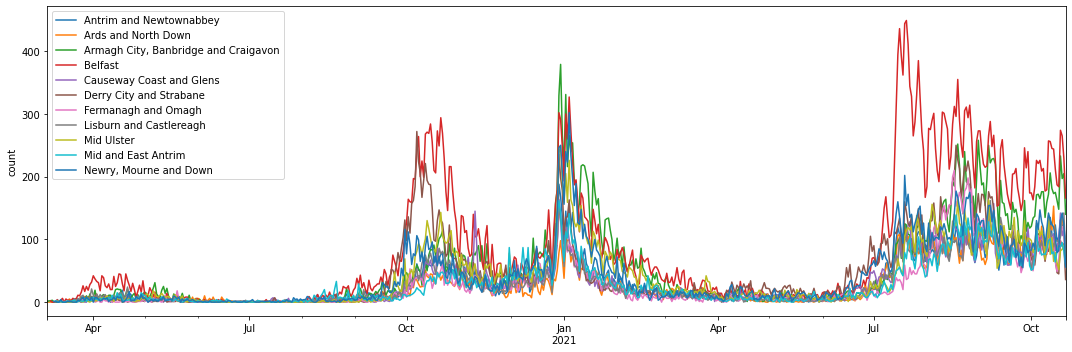

In [46]:
# prepare Covid-19 case data
date_range = ['2020-09-01', '2020-12-20']

cases = pd.read_csv('https://api.coronavirus.data.gov.uk/v2/data?areaType=ltla&metric=newCasesBySpecimenDate&format=csv&release=2021-10-24')
cases['date'] = pd.to_datetime(cases['date'])
cases = cases[cases['areaCode'].str.contains('N')].rename(columns={'areaCode':'LTLA', 'newCasesBySpecimenDate':'count'}).sort_values(['date','LTLA'])
_ = cases.set_index('date').groupby('areaName')['count'].plot(xlabel='', ylabel='count', figsize=(15,5), legend=True)

# subset data
cases = cases.loc[(cases['date']>=date_range[0]) & (cases['date']<date_range[1])].reset_index(drop=True)
case_data = cases.pivot(index='LTLA', columns='date', values='count').fillna(0)
case_data

In [7]:
# inputs forNorthern GEM model

popsize = np.array(population_array, dtype=np.float32).squeeze()

C = np.array(contact_matrix, dtype=np.float32)

s_init = popsize - 10
e_init = np.zeros_like(popsize)
i_init = np.ones_like(popsize) * 10
r_init = np.zeros_like(popsize)

In [8]:
from gem import GEM

prog = """
C = Matrix()
s_init = Vector()
e_init = Vector()
i_init = Vector()
r_init = Vector()
popsize = Vector()

beta ~ Gamma(2.0, 10.0)
phi ~ Gamma(2.0, 4.0)
nu = 0.5                # 2-day latent period
gamma ~ Gamma(2.0, 8.0) # 4-day average infectious period

Epidemic MyEpidemic() {

    S = State(init=s_init)
    E = State(init=e_init)
    I = State(init=i_init)
    R = State(init=r_init)
    
    [S -> E] = beta * (I + phi * matvec(C, (I / popsize))) / popsize
    [E -> I] = nu
    [I -> R] = gamma
}
epi ~ MyEpidemic()
"""

In [9]:
# instantiate model

model = GEM(prog, 
            const_data={'C': C,
                        's_init': s_init,
                        'e_init': e_init,
                        'i_init': i_init,
                        'r_init': r_init,
                        'popsize': popsize
                        }
            )

#print(model.pyprog)

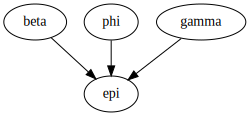

In [10]:
from gem.gemlang.dag import DAG

DAG(model.ast).dot()

In [11]:
sim = model.sample(1, condition_vars={'beta':0.43, 'phi':0.33, 'gamma':0.05})

2021-11-05 16:55:04.219778: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-05 16:55:04.219807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dell7510): /proc/driver/nvidia/version does not exist
2021-11-05 16:55:04.220115: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-05 16:55:04.885202: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
# from gem.plotting import plot_state_timeseries
# plot states summing over each meta population
# plot_state_timeseries(model['epi'], sim.epi, state_labels=('S', 'E', 'I', 'R'))

2021-11-05 16:55:06.739123: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


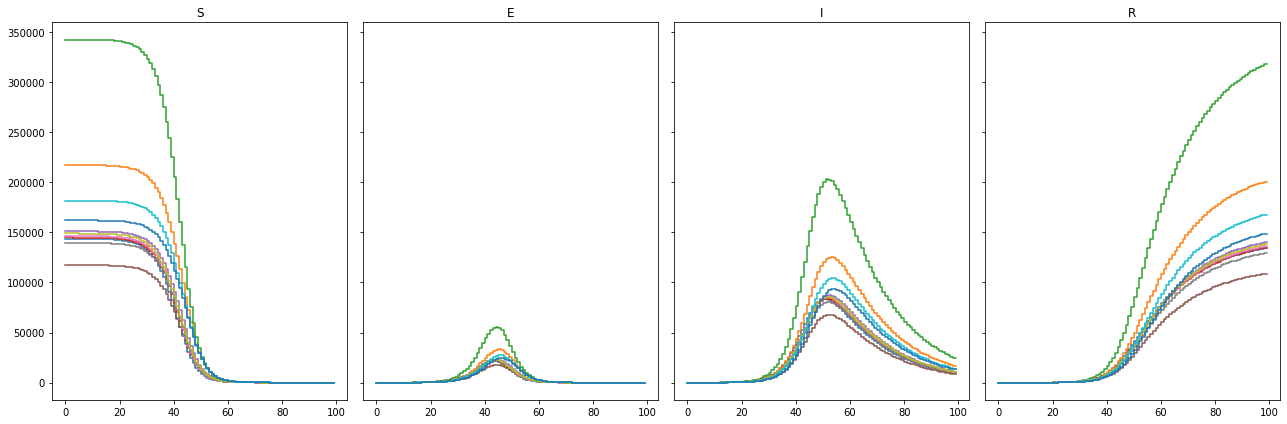

In [13]:
from gemlib.util import compute_state

state_labels = ['S', 'E', 'I', 'R']
state_timeseries = compute_state(model['epi'].initial_state, 
                                 sim.epi, 
                                 model['epi'].stoichiometry)

fig, ax = plt.subplots(nrows=1, ncols=len(state_labels), sharey=True)
x = np.tile(
        np.arange(state_timeseries.shape[-2]), (state_timeseries.shape[-3], 1)
    )

for i in np.arange(len(state_labels)):
    y = state_timeseries[...,i].numpy()
    _ = ax[i].step(x.T, y.T)
    ax[i].set_title(state_labels[i])

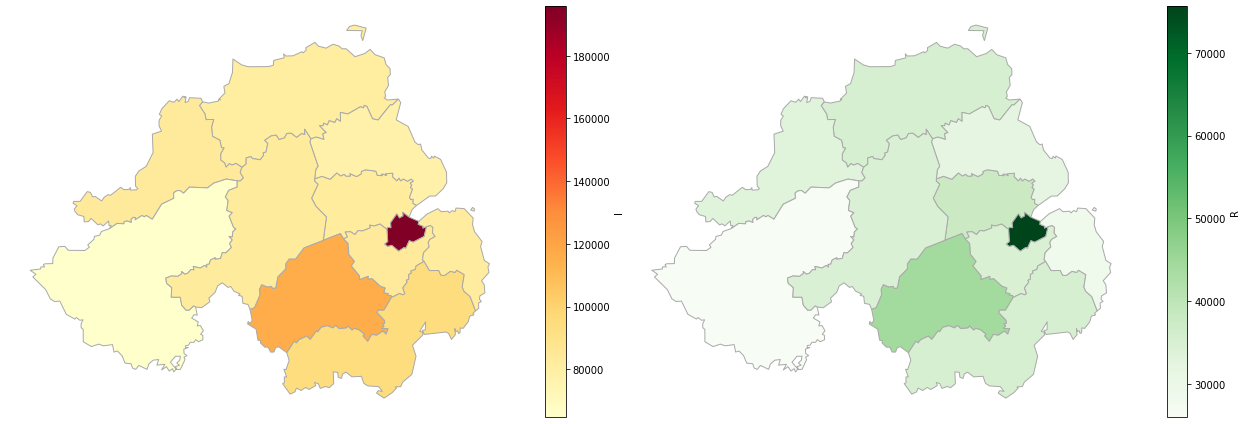

In [14]:
spatial_labels = pd.DataFrame(population_array.index)
state_labels_ = list(''.join(state_labels))

time_slice_df = pd.DataFrame(state_timeseries[:,50,:].numpy(), columns=list(state_labels_))
time_slice_df = spatial_labels.join(time_slice_df)

gdf = gdf.merge(time_slice_df, on='LTLA')

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
_ = gdf.plot(ax=ax[0], column='I', legend=True, legend_kwds={'label':'I'}, cmap='YlOrRd', edgecolor='#aaa', figsize=(8,4)).set_axis_off()
_ = gdf.plot(ax=ax[1], column='R', legend=True, legend_kwds={'label':'R'}, cmap='Greens', edgecolor='#aaa', figsize=(8,4)).set_axis_off()


# Inference using samples from model.sample()

In [15]:
posterior, accept = model.fit(observed={'epi': sim.epi},
                              n_samples=10000, 
                              num_burnin_steps=5000, 
                              init={'beta':0.4, 'phi':0.3, 'gamma':0.045})

Sampling...


2021-11-05 16:55:09.184260: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0xd45eb30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-05 16:55:09.184402: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-11-05 16:55:09.293859: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-11-05 16:55:09.346872: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:96] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2021-11-05 16:55:14.633211: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Done in 54.005269388999295 seconds


In [16]:
a = accept.inner_results.is_accepted.numpy()

print('acceptance ratio:', sum(a)/a.size)

acceptance ratio: 0.8394


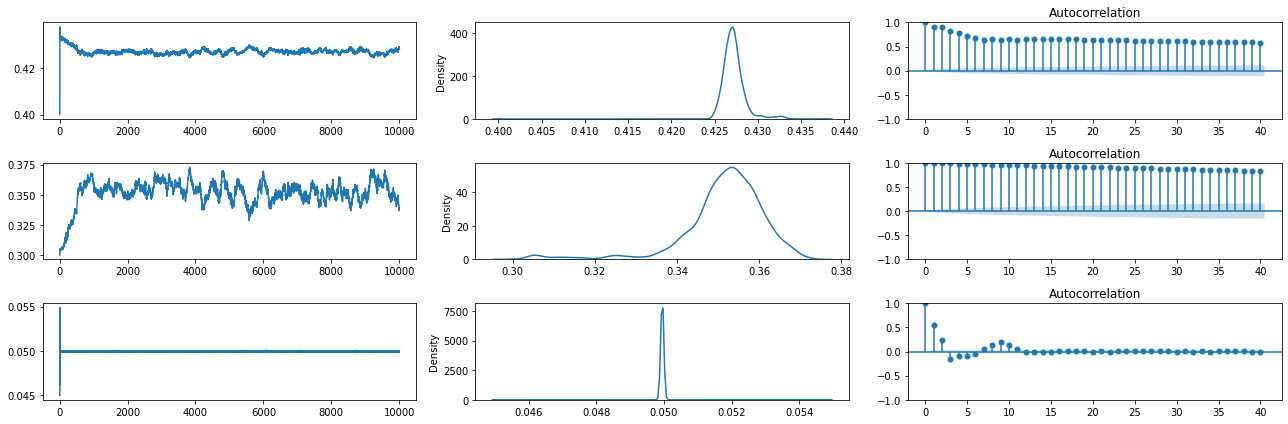

In [17]:
from gem.plotting import traceplot

_ = traceplot(posterior)

# Inference using NI data

In [49]:
buffer = 10 # ten day 'gap' between SE and IR transitions
data = np.array(case_data, dtype=np.float32)

IR = data[:,buffer:data.shape[1]]
EI = data[:,buffer//2:(data.shape[1]-buffer//2)]
SE = data[:,0:(data.shape[1]-buffer)]  #np.fliplr() # reverse order

#IR = data[:,0:(data.shape[1]-buffer)]
#EI = data[:,buffer//2:(data.shape[1]-buffer//2)]
#SE = data[:,buffer:data.shape[1]] 

transitions = tf.constant(np.stack((SE, EI, IR), axis=2))

Sampling...
Done in 11.845059408999077 seconds
acceptance ratio: 0.0


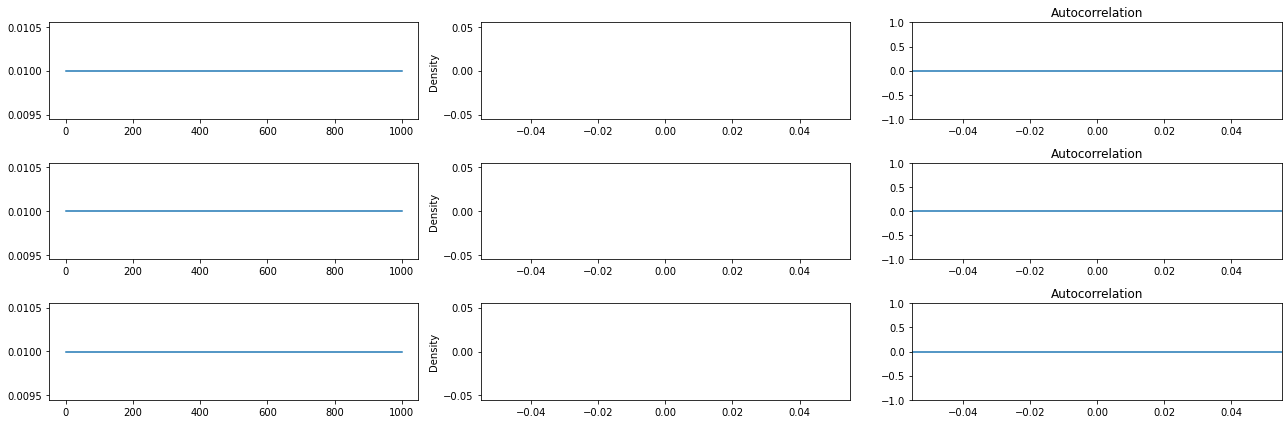

In [50]:
posterior, accept = model.fit(observed={'epi': transitions},
                              n_samples=1000, 
                              num_burnin_steps=500, 
                              init={'beta':0.01, 'phi':0.01, 'gamma':0.01})

a = accept.inner_results.is_accepted.numpy()
print('acceptance ratio:', sum(a)/a.size)

_ = traceplot(posterior)